In [1]:
import os
import ast
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)  # 不限制列内容宽度
pd.set_option('display.width', 0)            # 让 Jupyter/终端自动适配宽度
import matplotlib.pyplot as plt
from scipy import stats


CODE_MAP = {'a':0,'b':1,'c':2,'d':3,'e':4,'f':5,'g':6,'h':7,'i':8,'j':9,'k':10}
AUDIO_TYPE_MAP = {
        '0' : '正常',
        '1' : '噪声',
        '2' : '不相关中文',
        '3' : '不相关英文',
        '4' : '无意义语音',
        '5' : '音量小',
        '6' : '开头发音不完整',
        '7' : '空音频',
        '8' : '多说话人',
        # '正常': '0',
        # '噪声': '1',
        # '不相关中文': '2',
        # '不相关英文': '3',
        # '无意义语音': '4',
        # '音量小': '5',
        # '开头发音不完整': '6',
        # '空音频': '7',
        # '多说话人': '8'
    }

In [2]:
def llm_score_remap(infer_res:str, data_info:pd.DataFrame):
    scores = {}
    with open(infer_res, 'r', encoding='utf-8') as fr:
        lines = fr.readlines()
        for line in lines:
            line = line.strip().split('\t')
            try:
                key, score, porbabilities = line[0], line[1], line[2]
                score = CODE_MAP.get(score)
                score = float(score)
                scores[key] = score
            except:
                print(f"Error processing line: {line}")
    # change score2 to scores's value
    data_info['llm_score'] = data_info['wavname'].apply(lambda x: scores.get(x, -1))
    del data_info['score2']
    data_info = data_info.rename(columns={'llm_score': 'score2'})
    return data_info

def statistical_indicators_compute(data_info:pd.DataFrame, col_name:str='score2'):
    if col_name == 'score1':
        data_info['score1'] = data_info['score1'].astype(float) / 10.0
    data_info = data_info[data_info['audio_type'] != '0']
    # overall_pearson_corr = np.corrcoef(data_info['label'].tolist(), data_info[col_name].tolist())[0, 1]
    # overall_mae = np.mean(np.abs(data_info['label'] - data_info[col_name]))
    print(f"Overall Sample Size: {len(data_info)}")
    # print(f"Overall Pearson Correlation: {overall_pearson_corr:.4f}")
    # print(f"Overall MAE: {overall_mae:.4f}")

    data_type1 = data_info[data_info['audio_type'].isin(['1','5','6','8'])]
    data_type2 = data_info[data_info['audio_type'].isin(['2','3','4','7'])]
    # for subset, type_desc in zip([data_type1, data_type2], ['Type 1 (Noise, Low Volume, Incomplete Start, Multiple Speakers)', 'Type 2 (Irrelevant Chinese, Irrelevant English, Nonsense Speech, Empty Audio)']):
    for subset, type_desc in zip([data_type1], ['Type 1 (Noise, Low Volume, Incomplete Start, Multiple Speakers)']):
        if subset.empty:
            print(f"{type_desc} - No data available.")
            continue
        pearson_corr = np.corrcoef(subset['label'].tolist(), subset[col_name].tolist())[0, 1]
        mae = np.mean(np.abs(subset['label'] - subset[col_name]))
        print(f"{type_desc} Sample Size: {len(subset)}")
        print(f"  Pearson Correlation: {pearson_corr:.4f}")
        print(f"  MAE: {mae:.4f}")
    # 拒识
    data_type2['reject'] = (data_type2['label'] == 0) & (data_type2[col_name] == 0)
    # data_type2['reject'] = (data_type2[col_name] == 0)
    reject_rate = data_type2['reject'].sum() / len(data_type2)
    print(f"Type 2 Rejection Rate (label=0 and score2=0): {reject_rate:.4f}")

    for audio_code, type_name in AUDIO_TYPE_MAP.items():
        subset = data_info[data_info['audio_type'] == audio_code]
        # if audio_code in ['2','3','4','7']:
        #     subset = subset[subset['label'] == 0]
        if subset.empty:
            # print(f"Audio Type: {type_name} (Code: {audio_code}) - No data available.")
            continue
        print(f"Audio Type: {type_name} (Code: {audio_code}) Sample Size: {len(subset)}")
        if audio_code in ['2','3','4','7']:
            reject_rate = ((subset['label'] == 0) & (subset[col_name] == 0)).sum() / len(subset)
            print(f"  Rejection Rate (label=0 and score2=0): {reject_rate:.4f}")
        else:
            pearson_corr = np.corrcoef(subset['label'].tolist(), subset[col_name].tolist())[0, 1]
            mae = np.mean(np.abs(subset['label'] - subset[col_name]))
            print(f"  Pearson Correlation: {pearson_corr:.4f}")
            print(f"  MAE: {mae:.4f}")

def plot_distribution(data1, data2, data3, interval, labels=("Series 1", "Series 2", "Series 3"), title='Data Distribution', xlabel='Value'):
    # 设置绘图风格
    try:
        plt.style.use('seaborn-v0_8-whitegrid')
    except:
        plt.style.use('ggplot')

    # 预处理三组数据，去除 NaN
    d1 = np.array(data1, dtype=float)
    d2 = np.array(data2, dtype=float)
    d3 = np.array(data3, dtype=float)
    d1 = d1[~np.isnan(d1)]
    d2 = d2[~np.isnan(d2)]
    d3 = d3[~np.isnan(d3)]

    datasets = [d1, d2, d3]
    labels = list(labels) if labels is not None else ["Series 1", "Series 2", "Series 3"]
    colors = ["#5DADE2", "#58D68D", "#F5B041"]

    non_empty = [(d, labels[i], colors[i]) for i, d in enumerate(datasets) if d.size > 0]
    if len(non_empty) == 0:
        print("No valid data to plot.")
        return

    # KDE 曲线（百分比y轴）
    min_val = min(np.min(d) for d, _, _ in non_empty)
    max_val = max(np.max(d) for d, _, _ in non_empty)
    if max_val == min_val:
        max_val = min_val + interval
    x_grid = np.linspace(min_val, max_val, 1000)

    plt.figure(figsize=(12, 6), dpi=100)
    for d, lb, c in non_empty:
        try:
            kde = stats.gaussian_kde(d)
            pdf_values = kde(x_grid)
            fitted_curve = pdf_values * 100 * interval
            plt.plot(
                x_grid,
                fitted_curve,
                color=c,
                linestyle='-',
                linewidth=2.0,
                label=f"{lb} Fitted Curve (KDE)",
                zorder=3,
            )
        except Exception as e:
            print(f"Could not plot fitted curve for {lb}: {e}")

    # 箱线图
    box_data = [d for d, _, _ in non_empty]
    box_labels = [lb for _, lb, _ in non_empty]
    box_colors = [c for _, _, c in non_empty]
    bplot = plt.boxplot(
        box_data,
        vert=False,
        positions=[-5 - i*5 for i in range(len(box_data))],
        labels=box_labels,
        patch_artist=True,
        widths=3.0,
        showmeans=True,
        meanline=True,
        manage_ticks=True,
    )
    for patch, c in zip(bplot['boxes'], box_colors):
        patch.set_facecolor(c)
        patch.set_alpha(0.35)
        patch.set_edgecolor(c)
        patch.set_linewidth(1.2)
    for whisker in bplot['whiskers']:
        whisker.set_color('#666666')
        whisker.set_linewidth(1.1)
    for cap in bplot['caps']:
        cap.set_color('#666666')
        cap.set_linewidth(1.1)
    for median in bplot['medians']:
        median.set_color('#2C3E50')
        median.set_linewidth(1.4)
    for mean in bplot['means']:
        mean.set_color('#1F618D')
        mean.set_linewidth(1.2)
        
    plt.title(title, fontsize=16, fontweight='bold', pad=12)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.grid(True, which='major', axis='y', linestyle='--', alpha=0.6, zorder=0)
    plt.grid(False, axis='x')
    plt.legend(fontsize=11, frameon=True, shadow=True, loc='best')
    plt.tight_layout()
    plt.show()

def plot_box_only(data1, data2, data3, labels=("Series 1", "Series 2", "Series 3"), title='Box Plot', xlabel='Value'):
    # 设置绘图风格
    try:
        plt.style.use('seaborn-v0_8-whitegrid')
    except:
        plt.style.use('ggplot')

    d1 = np.array(data1, dtype=float)
    d2 = np.array(data2, dtype=float)
    d3 = np.array(data3, dtype=float)
    d1 = d1[~np.isnan(d1)]
    d2 = d2[~np.isnan(d2)]
    d3 = d3[~np.isnan(d3)]

    datasets = [d1, d2, d3]
    labels = list(labels) if labels is not None else ["Series 1", "Series 2", "Series 3"]
    colors = ["#5DADE2", "#58D68D", "#F5B041"]

    non_empty = [(d, labels[i], colors[i]) for i, d in enumerate(datasets) if d.size > 0]
    if len(non_empty) == 0:
        print("No valid data to plot.")
        return

    data_for_box = [d for d, _, _ in non_empty]
    labels_for_box = [lb for _, lb, _ in non_empty]
    colors_for_box = [c for _, _, c in non_empty]

    fig, ax = plt.subplots(figsize=(12, 3.5), dpi=100)
    bplot = ax.boxplot(
        data_for_box,
        vert=False,
        labels=labels_for_box,
        patch_artist=True,
        widths=0.65,
        showmeans=True,
        meanline=True,
        manage_ticks=True,
    )

    for patch, c in zip(bplot['boxes'], colors_for_box):
        patch.set_facecolor(c)
        patch.set_alpha(0.35)
        patch.set_edgecolor(c)
        patch.set_linewidth(1.2)
    for whisker in bplot['whiskers']:
        whisker.set_color('#666666')
        whisker.set_linewidth(1.1)
    for cap in bplot['caps']:
        cap.set_color('#666666')
        cap.set_linewidth(1.1)
    for median in bplot['medians']:
        median.set_color('#2C3E50')
        median.set_linewidth(1.4)
    for mean in bplot['means']:
        mean.set_color('#1F618D')
        mean.set_linewidth(1.2)

    ax.set_title(title, fontsize=14, fontweight='bold', pad=10)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.grid(True, axis='x', linestyle='--', alpha=0.4)
    ax.grid(False, axis='y')

    plt.tight_layout()
    plt.show()

In [7]:
# score1:线上模型得分，score2: llm模型得分
# data_info_path = '/mnt/pfs_l2/jieti_team/SFT/hupeng/data/tal-k12/test/abnormal_data/data_info_uniq_modify.csv'
# data_info = pd.read_csv(data_info_path, sep='\t', dtype={'wavname': str, 'text': str, 'score1': float, 'score2': float, 'audio_type': str})

data_info_path = '/mnt/pfs_l2/jieti_team/SFT/hupeng/data/en/audio_detect/test/label_only_abnormal_v2.csv'
data_info = pd.read_csv(data_info_path, sep='\t', dtype={'wavname': str, 'text': str, 'pron_score': float, 'audio_type': str})
data_info['score2'] = -1

# 交集数据
intersect_df = pd.read_csv('/mnt/pfs_l2/jieti_team/SFT/speech/fangdongyan/fdy_10.19.36.121/00-code_backup/tal_kh_evl_tools/data_pipeline/files/testdataset/test_dataset_0121_score.tsv', sep='\t')
data_info = data_info[data_info['wavname'].isin(intersect_df['wavname'].tolist())]

In [11]:
# new_infer_res = '/mnt/pfs_l2/jieti_team/SFT/hupeng/resources/PaMLLM/PaMLLM_kimi_v3.1/model_infer_ephch3/infer_res/abnormal_dataset.tsv'
# new_infer_res = '/mnt/pfs_l2/jieti_team/SFT/hupeng/resources/PaMLLM/PaMLLM_kimi_v3.1/infer_model_distill_epoch1_epoch3/infer_res/abnormal_dataset.tsv'
# new_infer_res = '/mnt/pfs_l2/jieti_team/SFT/hupeng/resources/PaMLLM/PaMLLM_kimi_v3.3/infer_model/infer_res/abnormal_dataset.tsv'
# new_infer_res = '/mnt/pfs_l2/jieti_team/SFT/hupeng/resources/PaMLLM/PaMLLM_kimi_v3.5/infer_model_b1_epoch2/infer_res/abnormal_dataset.tsv'
new_infer_res = '/mnt/pfs_l2/jieti_team/SFT/hupeng/resources/PaMLLM/PaMLLM_kimi_v3.6/infer_model_b1/infer_res/abnormal_dataset.tsv'

data_info_new = data_info.copy()
data_info_new = llm_score_remap(new_infer_res, data_info_new)
data_info_new = data_info_new[data_info_new['score2'] != -1]
statistical_indicators_compute(data_info_new, 'score2')
# PCC:0.6783    reject rate:0.9062
# v3.6 cpkt3000 0.6605 0.9297
# v3.6 cokt4000 0.6491 0.9197"
# v3.6 cpkt4581 0.6390 0.9279
# v3.6_b1 ckpt9000 0.6540 0.9161
# v3.6_b1 0.6496 0.9297

Overall Sample Size: 2351
Type 1 (Noise, Low Volume, Incomplete Start, Multiple Speakers) Sample Size: 1242
  Pearson Correlation: 0.6496
  MAE: 0.9461
Type 2 Rejection Rate (label=0 and score2=0): 0.9297
Audio Type: 噪声 (Code: 1) Sample Size: 792
  Pearson Correlation: 0.6063
  MAE: 0.9735
Audio Type: 不相关中文 (Code: 2) Sample Size: 378
  Rejection Rate (label=0 and score2=0): 0.9630
Audio Type: 不相关英文 (Code: 3) Sample Size: 93
  Rejection Rate (label=0 and score2=0): 0.7204
Audio Type: 无意义语音 (Code: 4) Sample Size: 458
  Rejection Rate (label=0 and score2=0): 0.9214
Audio Type: 音量小 (Code: 5) Sample Size: 41
  Pearson Correlation: 0.8786
  MAE: 0.8537
Audio Type: 开头发音不完整 (Code: 6) Sample Size: 167
  Pearson Correlation: 0.5751
  MAE: 1.0599
Audio Type: 空音频 (Code: 7) Sample Size: 180
  Rejection Rate (label=0 and score2=0): 0.9889
Audio Type: 多说话人 (Code: 8) Sample Size: 242
  Pearson Correlation: 0.6798
  MAE: 0.7934


In [6]:
data_info_new[data_info_new['audio_type'] == '3'][data_info_new['score2'] != 0]

,wavname,pron_score,text,wavpath,audio_type,label,score2
1674,17676994140101458182559934676992,86.0,all right,/mnt/pfs_l2/jieti_team/SFT/hupeng/data/en/audio_detect/wavs/wavs_260107/17676994140101458182559934676992.wav,3,0,7.0
1675,17677072316781458215349611241472,63.0,Is it slow?,/mnt/pfs_l2/jieti_team/SFT/hupeng/data/en/audio_detect/wavs/wavs_260107/17677072316781458215349611241472.wav,3,0,6.0
1678,17677071354841458214946143870976,60.0,Open the door.,/mnt/pfs_l2/jieti_team/SFT/hupeng/data/en/audio_detect/wavs/wavs_260107/17677071354841458214946143870976.wav,3,0,6.0
1924,17678682937891458890893067194368,79.0,then and now,/mnt/pfs_l2/jieti_team/SFT/speech/fangdongyan/fdy_10.19.36.121/00-code_backup/tal_kh_evl_tools/data_pipeline/files/260112/wav/17678682937891458890893067194368.wav,3,0,2.0
1925,17678725738191458908844814233600,83.0,What's this?,/mnt/pfs_l2/jieti_team/SFT/speech/fangdongyan/fdy_10.19.36.121/00-code_backup/tal_kh_evl_tools/data_pipeline/files/260112/wav/17678725738191458908844814233600.wav,3,0,3.0
1928,17678747593451458918011575029760,46.0,Is the bench old?,/mnt/pfs_l2/jieti_team/SFT/speech/fangdongyan/fdy_10.19.36.121/00-code_backup/tal_kh_evl_tools/data_pipeline/files/260112/wav/17678747593451458918011575029760.wav,3,0,3.0
1929,17678768821771458926915377602560,60.0,She has a bird.,/mnt/pfs_l2/jieti_team/SFT/speech/fangdongyan/fdy_10.19.36.121/00-code_backup/tal_kh_evl_tools/data_pipeline/files/260112/wav/17678768821771458926915377602560.wav,3,0,3.0
2493,17654577878441448780498340057088,52.0,This is an apple,/mnt/pfs_l2/jieti_team/SFT/hupeng/data/en/audio_detect/wavs/wavs_251212/17654577878441448780498340057088.wav,3,3,2.0
2501,17654069208501448567146703794176,83.0,It's cute!,/mnt/pfs_l2/jieti_team/SFT/hupeng/data/en/audio_detect/wavs/wavs_251212/17654069208501448567146703794176.wav,3,5,6.0
2502,17654552408651448769815536250880,12.0,Good morning.,/mnt/pfs_l2/jieti_team/SFT/hupeng/data/en/audio_detect/wavs/wavs_251212/17654552408651448769815536250880.wav,3,0,7.0


In [42]:
# abmorbal 测试集新版本分析
analysis_df = pd.DataFrame({
    'wavname': data_info['wavname'],
    'text': data_info['text'],
    'audio_type': data_info['audio_type'],
    'label': data_info['label'],
    'old_llm': data_info['score2']
})
analysis_df['new_llm'] = pd.merge(data_info_new[['wavname', 'score2']], analysis_df[['wavname']], on='wavname', how='left')['score2']
# analysis_df = analysis_df[analysis_df['audio_type'] == '1']
analysis_df['diff'] = abs(analysis_df['label'] - analysis_df['old_llm'])
analysis_df['new_diff'] = abs(analysis_df['label'] - analysis_df['new_llm'])
analysis_df['better'] = analysis_df['new_diff'] < analysis_df['diff']
analysis_df['same'] = analysis_df['new_diff'] == analysis_df['diff']
analysis_df['worse'] = analysis_df['new_diff'] > analysis_df['diff']
analysis_df.sort_values(by='diff', ascending=False, inplace=True)

print(analysis_df['better'].sum(), analysis_df['same'].sum(), analysis_df['worse'].sum())
print(analysis_df[analysis_df['same'] == True]['new_diff'].mean())
print([analysis_df[analysis_df['better'] == True]['diff'].mean(), analysis_df[analysis_df['better'] == True]['new_diff'].mean()])
print([analysis_df[analysis_df['worse'] == True]['diff'].mean(), analysis_df[analysis_df['worse'] == True]['new_diff'].mean()])
print([analysis_df['diff'].mean(), analysis_df['new_diff'].mean()])

169 929 152
0.30355220667384286
[np.float64(2.0236686390532546), np.float64(0.31952662721893493)]
[np.float64(0.5197368421052632), np.float64(2.210526315789474)]
[np.float64(0.5624), np.float64(0.5376)]


In [43]:
# audio_type 贡献度与薄弱点分析（label vs old_llm/new_llm）
import math

def safe_corr(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    if x.size < 2 or y.size < 2 or np.std(x) == 0 or np.std(y) == 0:
        return np.nan
    return float(np.corrcoef(x, y)[0, 1])

# 全局 PCC
pcc_old_all = safe_corr(analysis_df['label'], analysis_df['old_llm'])
pcc_new_all = safe_corr(analysis_df['label'], analysis_df['new_llm'])
N = len(analysis_df)

rows = []
for atype, g in analysis_df.groupby('audio_type'):
    n = len(g)
    pct = n / N if N else 0
    pcc_old = safe_corr(g['label'], g['old_llm'])
    pcc_new = safe_corr(g['label'], g['new_llm'])
    mae_old = float(np.mean(np.abs(g['label'] - g['old_llm']))) if n else np.nan
    mae_new = float(np.mean(np.abs(g['label'] - g['new_llm']))) if n else np.nan
    mae_change = mae_new - mae_old
    contrib_new = abs(pcc_new) * pct  # 简单占比加权贡献度
    # 留一法：移除该类后再算全局 PCC
    remain = analysis_df[analysis_df['audio_type'] != atype]
    pcc_new_without = safe_corr(remain['label'], remain['new_llm']) if len(remain) >= 2 else np.nan
    delta_new = pcc_new_all - pcc_new_without if not math.isnan(pcc_new_all) and not math.isnan(pcc_new_without) else np.nan
    rows.append({
        'audio_type': atype,
        'n': n,
        'pct': pct,
        'pcc_old': pcc_old,
        'pcc_new': pcc_new,
        'mae_old': mae_old,
        'mae_new': mae_new,
        'mae_change': mae_change,
        # 'contrib_new': contrib_new,
        # 'pcc_new_without': pcc_new_without,
        # 'delta_new': delta_new,
    })

summary_df = pd.DataFrame(rows).sort_values(by='mae_change', ascending=True)
summary_df = summary_df[summary_df['audio_type'] != '0']
summary_df['audio_type'] = summary_df['audio_type'].map(AUDIO_TYPE_MAP)
print('Overall PCC old vs label:', pcc_old_all)
print('Overall PCC new vs label:', pcc_new_all)
summary_df

Overall PCC old vs label: 0.9432436231746196
Overall PCC new vs label: 0.9480245817338018


,audio_type,n,pct,pcc_old,pcc_new,mae_old,mae_new,mae_change
1,噪声,212,0.1696,0.611558,0.684358,1.245283,1.023585,-0.221698
5,音量小,42,0.0336,0.794051,0.899544,0.988095,0.809524,-0.178571
2,不相关中文,173,0.1384,NaN,NaN,0.092486,0.086705,-0.005780
3,不相关英文,54,0.0432,NaN,NaN,0.222222,0.222222,0.000000
7,空音频,200,0.1600,NaN,NaN,0.000000,0.000000,0.000000
4,无意义语音,206,0.1648,0.294953,0.443928,0.266990,0.276699,0.009709
8,多说话人,200,0.1600,0.733966,0.674747,0.755000,0.780000,0.025000
6,开头发音不完整,161,0.1288,0.721362,0.555149,1.003106,1.111801,0.108696


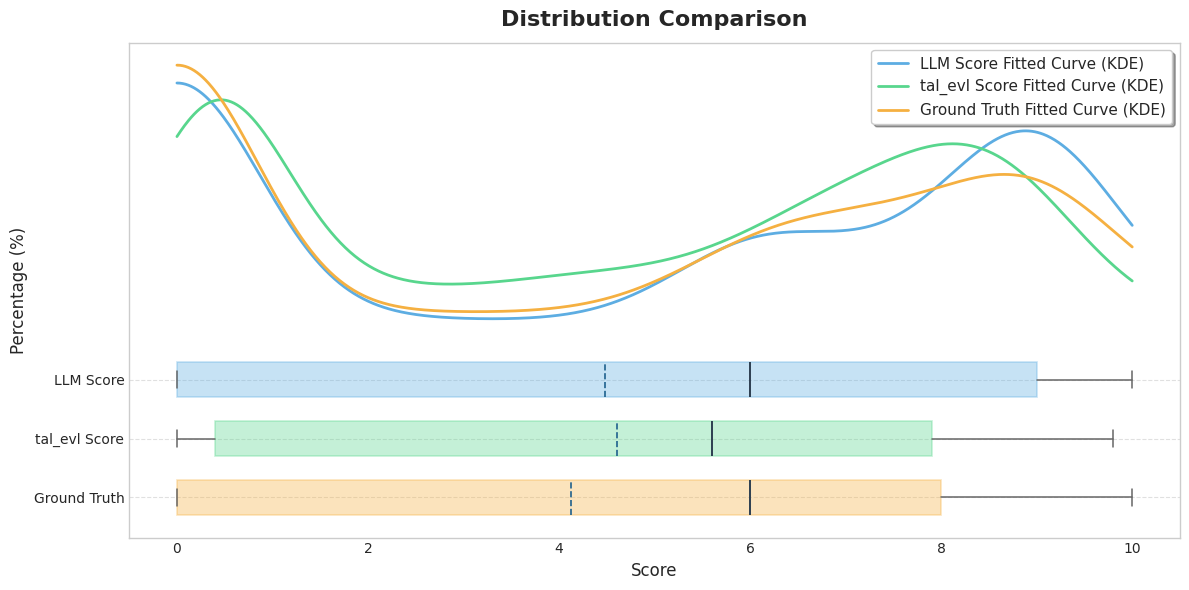

In [18]:
scores_llm = data_info_new['score2'].tolist()
scores_tal = (data_info_new['pron_score']/10).tolist()
scores_label = data_info_new['label'].tolist()

plot_distribution(
    scores_llm,
    scores_tal,
    scores_label,
    interval=1,
    labels=("LLM Score", "tal_evl Score", "Ground Truth"),
    title='Distribution Comparison',
    xlabel='Score'
)

# plot_box_only(
#     scores_llm,
#     scores_tal,
#     scores_label,
#     labels=("LLM Score", "tal_evl Score", "Ground Truth"),
#     title='Box Plot Comparison',
#     xlabel='Score'
# )

In [59]:
# batch4 新旧对比
label_batch4 = '/mnt/pfs_l2/jieti_team/SFT/hupeng/data/tal-k12/test/label_snt_score_batch4'
data_info_batch4 = pd.read_csv(label_batch4, sep='\t', header=None, names=['wavname', 'text', 'label', 'audio_type'], dtype={'wavname': str, 'text': str, 'label': float, 'audio_type': str})
data_info_batch4['audio_type'].fillna('正常', inplace=True)

old_score = '/mnt/pfs_l2/jieti_team/SFT/hupeng/resources/PaMLLM/PaMLLM_kimi_v2.3/model_infer_2/infer_res/label_snt_score_batch4'
old_df = pd.read_csv(old_score, sep='\t', header=None, names=['wavname', 'score_old', 'probabilities'])
old_df['score_old'] = old_df['score_old'].str.replace(r'用户句子发音评测\(accuracy\)结果为：|。', '', regex=True)
old_df['score_old'] = old_df['score_old'].astype(float)

CODE_MAP = {'a':0,'b':1,'c':2,'d':3,'e':4,'f':5,'g':6,'h':7,'i':8,'j':9,'k':10}
new_score = '/mnt/pfs_l2/jieti_team/SFT/hupeng/resources/PaMLLM/PaMLLM_kimi_v3.3/infer_model/infer_res/label_snt_score_batch4'
new_df = pd.read_csv(new_score, sep='\t', header=None, names=['wavname', 'score_new', 'probabilities'])
new_df['score_new'] = new_df['score_new'].map(CODE_MAP)

data_info_batch4 = pd.merge(data_info_batch4, old_df[['wavname', 'score_old']], on='wavname', how='inner')
data_info_batch4 = pd.merge(data_info_batch4, new_df[['wavname', 'score_new']], on='wavname', how='inner')
data_info_batch4.dropna(inplace=True)
old_pcc = np.corrcoef(data_info_batch4['label'].tolist(), data_info_batch4['score_old'].tolist())[0, 1]
new_pcc = np.corrcoef(data_info_batch4['label'].tolist(), data_info_batch4['score_new'].tolist())[0, 1]
print(f"Batch4 Overall - Old PCC: {old_pcc:.4f}, New PCC: {new_pcc:.4f}")
for key, value in AUDIO_TYPE_MAP.items():
    tmp = data_info_batch4[data_info_batch4['audio_type'] == value]
    old_mae = np.mean(np.abs(tmp['label'] - tmp['score_old']))
    new_mae = np.mean(np.abs(tmp['label'] - tmp['score_new']))
    old_pcc = np.corrcoef(tmp['label'].tolist(), tmp['score_old'].tolist())[0, 1]
    new_pcc = np.corrcoef(tmp['label'].tolist(), tmp['score_new'].tolist())[0, 1]
    print(f"Audio Type: {value} (Code: {key}, N={len(tmp)}) - Old MAE: {old_mae:.4f}, New MAE: {new_mae:.4f}")
    print(f"  Old PCC: {old_pcc:.4f}, New PCC: {new_pcc:.4f}")

Batch4 Overall - Old PCC: 0.8739, New PCC: 0.8910
Audio Type: 正常 (Code: 0, N=5905) - Old MAE: 0.8704, New MAE: 0.7820
  Old PCC: 0.7093, New PCC: 0.7419
Audio Type: 噪声 (Code: 1, N=1084) - Old MAE: 0.9737, New MAE: 0.9244
  Old PCC: 0.7319, New PCC: 0.7257
Audio Type: 不相关中文 (Code: 2, N=101) - Old MAE: 0.0990, New MAE: 0.0297
  Old PCC: 0.7036, New PCC: 1.0000
Audio Type: 不相关英文 (Code: 3, N=45) - Old MAE: 0.6444, New MAE: 1.0667
  Old PCC: 0.1077, New PCC: -0.0740
Audio Type: 无意义语音 (Code: 4, N=89) - Old MAE: 0.4607, New MAE: 0.4831
  Old PCC: 0.3196, New PCC: 0.1319
Audio Type: 音量小 (Code: 5, N=37) - Old MAE: 1.5405, New MAE: 1.4324
  Old PCC: 0.5623, New PCC: 0.5824
Audio Type: 开头发音不完整 (Code: 6, N=130) - Old MAE: 1.1231, New MAE: 0.9308
  Old PCC: 0.5747, New PCC: 0.5674
Audio Type: 空音频 (Code: 7, N=213) - Old MAE: 0.0000, New MAE: 0.0000
  Old PCC: nan, New PCC: nan
Audio Type: 多说话人 (Code: 8, N=172) - Old MAE: 0.8285, New MAE: 0.7558
  Old PCC: 0.7573, New PCC: 0.7578


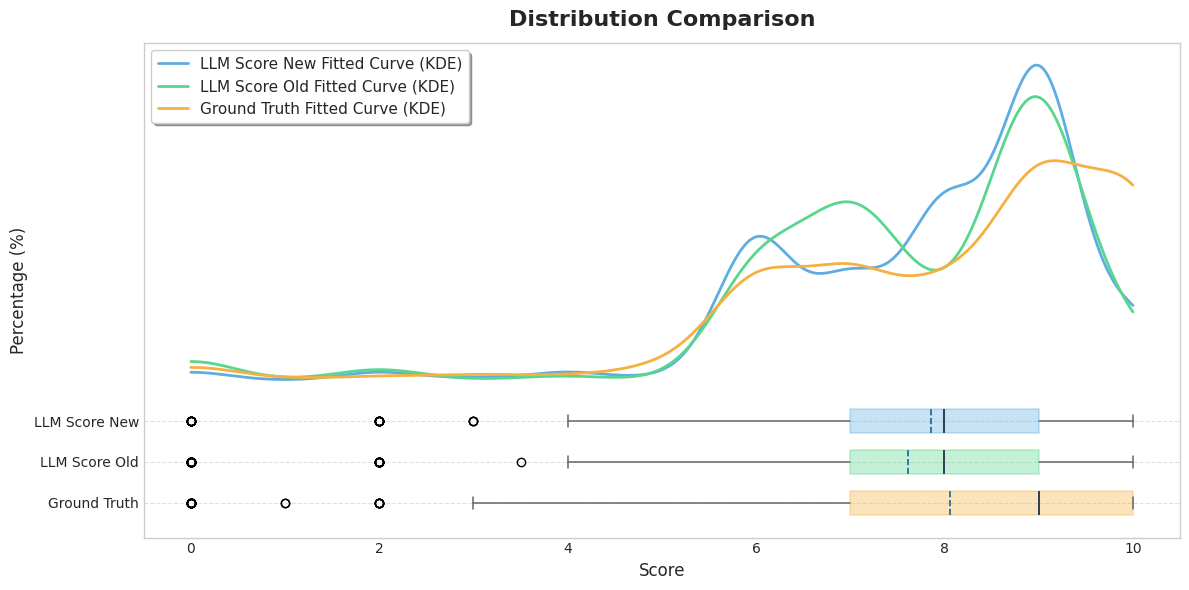

In [64]:
plot_distribution(
    data_info_batch4[data_info_batch4['audio_type'] == '噪声']['score_new'].tolist(),
    data_info_batch4[data_info_batch4['audio_type'] == '噪声']['score_old'].tolist(),
    data_info_batch4[data_info_batch4['audio_type'] == '噪声']['label'].tolist(),
    interval=1,
    labels=("LLM Score New", "LLM Score Old", "Ground Truth"),
    title='Distribution Comparison',
    
    xlabel='Score'
)

In [106]:
import random

file1 = '/mnt/pfs_l2/jieti_team/SFT/hupeng/data/tal-k12/test/label_sent_score'
file_fake = '/mnt/pfs_l2/jieti_team/SFT/hupeng/data/tal-k12/test/label_snt_score_batch4'
fake_text_dic = {}
with open(file_fake, 'r', encoding='utf-8') as fr:
    lines = fr.readlines()
    for line in lines:
        line = line.strip().split('\t')
        text = line[1].lower()
        fake_text_dic[text] = set(text.split())

new_pa_text = {}
with open(file1, 'r', encoding='utf-8') as fr:
    lines = fr.readlines()
    for line in lines:
        try:
            line = line.strip().split('\t')
            key, text = line[0], line[1].lower()
            words = set(text.split())
            fake_text = random.sample(fake_text_dic.keys(), 1)[0]
            fake_words = fake_text_dic[fake_text]
            while fake_words & words:
                fake_text = random.sample(fake_text_dic.keys(), 1)[0]
                fake_words = fake_text_dic[fake_text]
            new_pa_text[key] = fake_text
        except Exception as e:
            print(fake_text, fake_words, words, e)
with open('/mnt/pfs_l2/jieti_team/SFT/hupeng/data/tal-k12/test/label_sent_score_fake.txt', 'w', encoding='utf-8') as fw:
    for k, v in new_pa_text.items():
        fw.write(f"{k}\t{v}\t0\n")

In [107]:
fake_df = pd.read_csv('/mnt/pfs_l2/jieti_team/SFT/hupeng/resources/PaMLLM/PaMLLM_kimi_v3.3/infer_model/infer_res/label_sent_score_fake.txt', sep='\t', names=['wavname', 'score', 'prob'])
fake_df['score'] = fake_df['score'].map(CODE_MAP)
fake_df['score'].value_counts()

score
0     1676
2      264
4      178
6      127
3       64
5       26
8       12
9        2
10       1
Name: count, dtype: int64